# Data understanding

In [20]:
import os
import cv2 as cv
import numpy as np
import tensorflow as tf 
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
DATA_PATH = 'Water_Bodies_Dataset' 
IMAGES_PATH = 'Water_Bodies_Dataset\Images' 
MASKS_PATH = 'Water_Bodies_Dataset\Masks' 

In [3]:
!dir Water_Bodies_Dataset

 El volumen de la unidad C no tiene etiqueta.
 El n�mero de serie del volumen es: 54B2-0A88

 Directorio de c:\Users\Marco\Documents\Python Scripts\proyectos\image-segmentation\Water_Bodies_Dataset

22/01/2024  04:07 p.�m.    <DIR>          .
22/01/2024  04:07 p.�m.    <DIR>          ..
22/01/2024  04:07 p.�m.    <DIR>          Images
22/01/2024  04:07 p.�m.    <DIR>          Masks
               0 archivos              0 bytes
               4 dirs  118.450.450.432 bytes libres


In [4]:
!dir Water_Bodies_Dataset\Images

 El volumen de la unidad C no tiene etiqueta.
 El n�mero de serie del volumen es: 54B2-0A88

 Directorio de c:\Users\Marco\Documents\Python Scripts\proyectos\image-segmentation\Water_Bodies_Dataset\Images

22/01/2024  04:07 p.�m.    <DIR>          .
22/01/2024  04:07 p.�m.    <DIR>          ..
18/05/2020  01:02 a.�m.           868.560 water_body_1.jpg
18/05/2020  01:02 a.�m.            12.162 water_body_10.jpg
18/05/2020  01:02 a.�m.            35.099 water_body_100.jpg
18/05/2020  01:02 a.�m.            15.913 water_body_1000.jpg
18/05/2020  01:02 a.�m.            10.999 water_body_1002.jpg
18/05/2020  01:02 a.�m.            60.402 water_body_1003.jpg
18/05/2020  01:02 a.�m.            16.556 water_body_1004.jpg
18/05/2020  01:02 a.�m.             3.231 water_body_1006.jpg
18/05/2020  01:02 a.�m.             4.827 water_body_1008.jpg
18/05/2020  01:02 a.�m.             3.266 water_body_101.jpg
18/05/2020  01:02 a.�m.            14.510 water_body_1010.jpg
18/05/2020  01:02 a.�m.       

In [5]:
!dir Water_Bodies_Dataset\Masks

 El volumen de la unidad C no tiene etiqueta.
 El n�mero de serie del volumen es: 54B2-0A88

 Directorio de c:\Users\Marco\Documents\Python Scripts\proyectos\image-segmentation\Water_Bodies_Dataset\Masks

22/01/2024  04:07 p.�m.    <DIR>          .
22/01/2024  04:07 p.�m.    <DIR>          ..
18/05/2020  01:03 a.�m.           714.257 water_body_1.jpg
18/05/2020  01:03 a.�m.            21.398 water_body_10.jpg
18/05/2020  01:03 a.�m.            16.933 water_body_100.jpg
18/05/2020  01:03 a.�m.            20.450 water_body_1000.jpg
18/05/2020  01:03 a.�m.            11.373 water_body_1002.jpg
18/05/2020  01:03 a.�m.            72.311 water_body_1003.jpg
18/05/2020  01:03 a.�m.            14.596 water_body_1004.jpg
18/05/2020  01:03 a.�m.             4.079 water_body_1006.jpg
18/05/2020  01:03 a.�m.             7.159 water_body_1008.jpg
18/05/2020  01:03 a.�m.             3.644 water_body_101.jpg
18/05/2020  01:03 a.�m.            12.515 water_body_1010.jpg
18/05/2020  01:03 a.�m.        

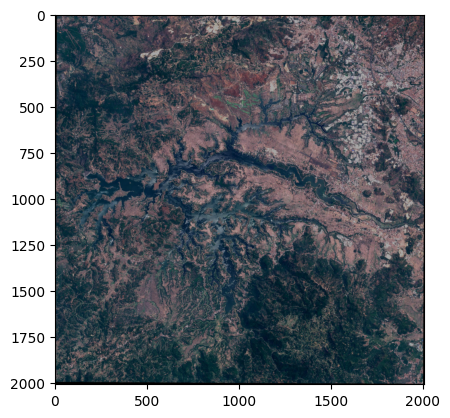

In [6]:
water_image = cv.cvtColor(cv.imread('Water_Bodies_Dataset\Images\water_body_1.jpg'), cv.COLOR_BGR2RGB)
plt.imshow(water_image)
plt.show(block=False)

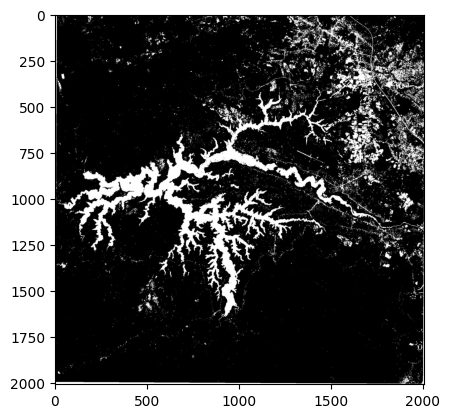

In [7]:
water_mask = cv.cvtColor(cv.imread('Water_Bodies_Dataset\Masks\water_body_1.jpg'), cv.COLOR_BGR2RGB)
plt.imshow(water_mask)
plt.show(block=False)

In [8]:
water_bodies_images = os.listdir(IMAGES_PATH)
mask_images = os.listdir(MASKS_PATH)

print(f'The number of images of water bodies is: {len(water_bodies_images)}')
print(f'The number of images of masks is: {len(mask_images)}')

The number of images of water bodies is: 2841
The number of images of masks is: 2841


## Data loading

In [9]:
IMG_SIZE = (2000,2000)

In [10]:
X = []
Y = []

In [11]:
filenames = os.listdir('Water_Bodies_Dataset\Images')

In [12]:
for file in filenames:

    path_image = os.path.join(IMAGES_PATH, file)
    img = image.load_img(path_image, target_size=(512, 512,3))
    img_array = np.array(img)
    img_array = img_array/255
    X.append(img_array)


    path_mask = os.path.join(MASKS_PATH, file)
    mask = image.load_img(path_mask, target_size=(512, 512,3))
    mask_array = np.array(mask)
    Y.append(mask_array)

In [13]:
print(len(Y))
print(len(X))

2841
2841


In [16]:
print(type(Y[0]))
print(type(X[0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


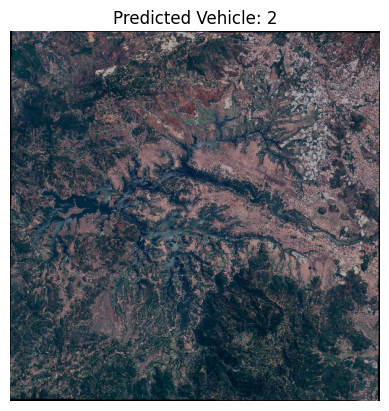

In [14]:
plt.imshow(X[0])
plt.axis('off')
plt.title(f"Predicted Vehicle: {2}")
plt.show()

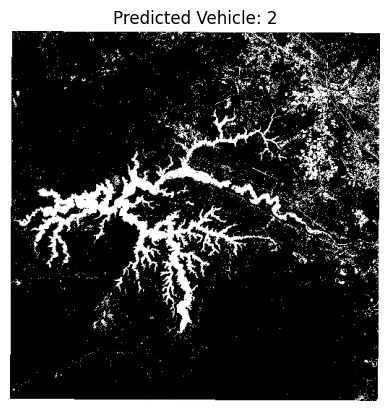

In [15]:
plt.imshow(Y[0])
plt.axis('off')
plt.title(f"Predicted Vehicle: {2}")
plt.show()

In [ ]:
#Split data on train, validation and test sets

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.8, shuffle = True, random_state=42)

In [23]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

2272
569
2272
569


## Model Creation

In [34]:
def encoderBlock(n_filters):
    layer = keras.Sequential()
    
    initializer = keras.initializers.he_normal()
    
    layer.add(keras.layers.Conv2D(filters=n_filters,
                                  kernel_size=(3,3),
                                  padding="same",
                                  kernel_initializer=initializer))
    layer.add(keras.layers.BatchNormalization())
    layer.add(keras.layers.LeakyReLU())
    layer.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    
    
    return layer

encoderBlock(32)

In [39]:
def decoderBlock(n_filters, apply_dropout=False):
    layer = keras.Sequential()
    
    initializer = keras.initializers.he_normal()
    
    layer.add(keras.layers.Conv2DTranspose(filters=n_filters,
                                  kernel_size=(3,3),
                                  padding="same",
                                  kernel_initializer=initializer))
    layer.add(keras.layers.BatchNormalization())
    layer.add(keras.layers.LeakyReLU())
    
    if apply_dropout:
        layer.add(keras.layrs.Dropout(0.3))
    
    return layer

decoderBlock(32)

In [ ]:
#layer.add(keras.layers.MaxPooling2D(pool_size=(2,2)))